In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import yt
import yt.units as u
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
plt.rcParams.update({
    "text.usetex": True})

In [3]:
G = u.gravitational_constant
q0 = 1e6
beta = 1
M = q0 * u.Msun
rT = q0**(1 / 3) * u.Rsun
deltaE = (G * M / rT**2 * u.Rsun).in_cgs()

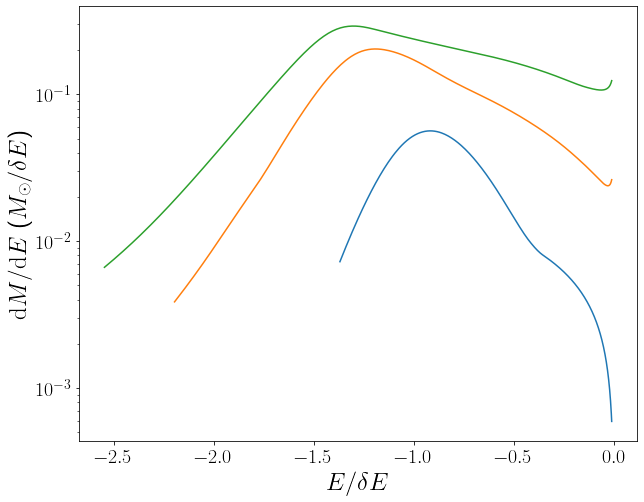

In [4]:
f, ax = plt.subplots(figsize=(10, 8))
ax.set_yscale('log')
ax.set_xlabel(r'$E/\delta E$', fontsize=25)
ax.set_ylabel(r'$\mathrm{d} M$/$\mathrm{d} E$ ($M_\odot/\delta E$)', fontsize=25)
ax.tick_params(labelsize=20)

files = ['1.000.dat', '1.500.dat', '2.000.dat']
for f in files:
    dmdt_t0 = np.loadtxt(f)
    t0 = dmdt_t0[:, 0]
    dmdt0 = dmdt_t0[:, 1]
    dedt0 = (2 / 3 * (G**2 * M**2 * np.pi**2 / 2)**(1 / 3) *
             (t0 * u.day)**(-5 / 3)).in_cgs()
    dmde0 = (dmdt0 * (u.Msun / u.yr) / dedt0).in_cgs()
    E = -((G**2 * M**2 * np.pi**2 / 2)**(1 / 3) * (t0 * u.day)**(-2 / 3)).in_cgs()
    E_dE = E / deltaE
    dmde_dE = dmde0 * deltaE
    ax.plot(E_dE, dmde_dE.in_units('Msun'))
ax.set_yscale('log')

In [5]:
class TDE:
    def __init__(self, q=q0, Ecc=1, beta=1, file='1.000.dat'):
        dmdt_t0 = np.loadtxt(f)
        t0 = dmdt_t0[:, 0]
        dmdt0 = dmdt_t0[:, 1]
        dedt0 = (2 / 3 * (G**2 * M**2 * np.pi**2 / 2)**(1 / 3) *
                 (t0 * u.day)**(-5 / 3)).in_cgs()
        dmde0 = (dmdt0 * (u.Msun / u.yr) / dedt0).in_cgs()
        E = -((G**2 * M**2 * np.pi**2 / 2)**(1 / 3) * (t0 * u.day)**(-2 / 3)).in_cgs()
        E_dE = E / deltaE
        dmde_dE = dmde0 * deltaE
        self.M = q * u.Msun
        self.Ecc = Ecc
        self.beta = beta
        self.rT = q**(1 / 3) * u.Rsun
        self.deltaE = (G * self.M / self.rT**2 * u.Rsun).in_cgs()

        self.E = self.E_Ecc(E_dE * self.deltaE)
        self.T = ((-self.E**3 * 2)**(-1 / 2) * np.pi * G * self.M).in_units('day')

        self.dmde = dmde_dE / self.deltaE
        dedt = 2 / 3 * ((G**2 * self.M**2 * np.pi**2 / 2)**(1 / 3) *
                        self.T**(-5 / 3)).in_cgs()
        self.dmdt = (dedt * self.dmde).in_units('Msun/yr')

        self.Tpeak = self.T[np.argmax(self.dmdt)].in_units('day')
        if self.Eorb == 0:
            self.Period = np.inf
        else:
            self.Period = 2 * np.pi * G * self.M / (-2 * self.Eorb)**(3 / 2)
            self.Period = self.Period.in_units('day')

    def E_Ecc(self, E):
        if self.Ecc == 1:
            self.Eorb = 0
        else:
            a = self.rT / self.beta / (1 - self.Ecc)
            self.Eorb = -G * self.M / 2 / a
        return E + self.Eorb

## Tpeak v.s. other parameters

Text(0, 0.5, '$T_\\mathrm{peak}\\ \\mathrm{[day]}$')

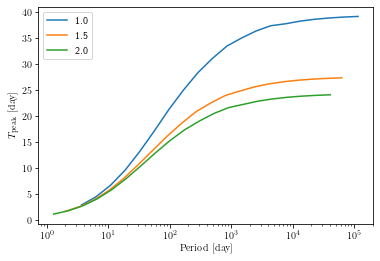

In [6]:
Ecc_range = 1 - np.logspace(-1, -4, 20)
for f in files:
    tpeak = []
    P = []
    for Ecc in Ecc_range:
        tde = TDE(Ecc=Ecc, file=f, beta=float(f[:3]), q=1e6)
        dmdt_Ecc = tde.dmdt
        P = np.append(P, tde.Period)
        tpeak = np.append(tpeak, tde.Tpeak)
    plt.plot(P, tpeak, label=f[:3])
plt.legend()
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\mathrm{Period\ [day]}$')
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$')

In [7]:
e_cri_1 = 0.9825

In [8]:
def P2Ecc(P, M=1 * u.Msun, R=1 * u.Rsun, beta=1):
    return 1 - (4 * np.pi**2 / P**2 / G / M)**(1 / 3) * R / beta

Text(0.5, 0, '$q$')

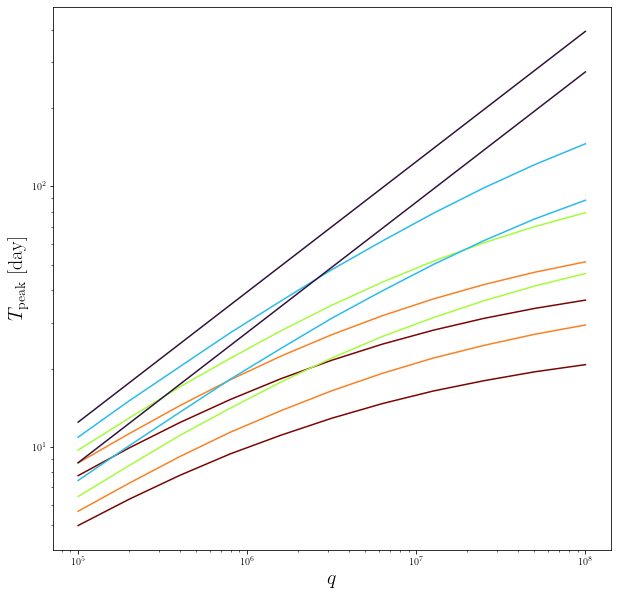

In [9]:
plt.figure(figsize=(10, 10))
q_range = np.logspace(5, 8, 11)

cmap = cm.get_cmap('turbo', 5)

for f in files[:2]:
    for level, ecc in enumerate(np.linspace(1, e_cri_1, 5)):
        #tde0 = [TDE(q=q, file=f, beta=float(f[:3])) for q in q_range]
        #plt.loglog(q_range, [tde.Tpeak for tde in tde0])
        tde_temp = [TDE(q=q, Ecc=ecc, file=f, beta=float(f[:3])) for q in q_range]
        plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
        Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                                   ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                             2)
        '''plt.loglog(q_range,
                   tde_temp[0].Tpeak * Tpeak_ratio_analyt_temp,
                   color=cmap(level),
                   linestyle=':')'''
        
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$', fontsize=20)
plt.xlabel('$q$', fontsize=20)

Text(0.5, 0, '$q$')

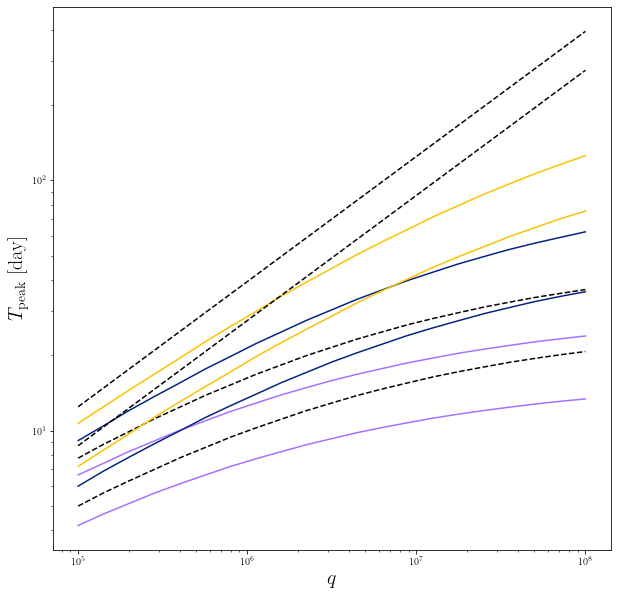

In [14]:
plt.figure(figsize=(10, 10))
q_range = np.logspace(5, 8, 21)

Ecc = P2Ecc(P=np.array([30, 100, 300])*u.day)

cmap = cm.get_cmap('Haze', 3)

for f in files[:2]:
    tde0 = [TDE(q=q, file=f, beta=float(f[:3])) for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde0], color='k', linestyle='--')
    tde_cri = [TDE(q=q, Ecc=e_cri_1, file=f, beta=float(f[:3])) for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde_cri], color='k', linestyle='--')
    for level, ecc in enumerate(Ecc):
        tde_temp = [TDE(q=q, Ecc=ecc, file=f, beta=float(f[:3])) for q in q_range]
        plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
        Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                                   ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                             2)
        '''plt.loglog(q_range,
                   tde_temp[0].Tpeak * Tpeak_ratio_analyt_temp,
                   color=cmap(level),
                   linestyle=':')'''
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$', fontsize=20)
plt.xlabel('$q$', fontsize=20)

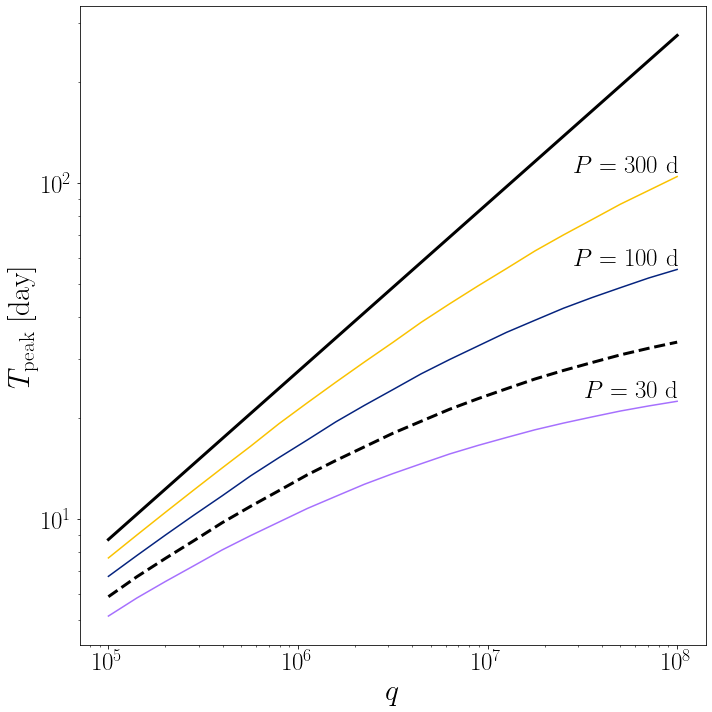

In [39]:
plt.figure(figsize=(10, 10))
q_range = np.logspace(5, 8, 21)
tde0 = [TDE(q=q, file='1.000.dat') for q in q_range]
plt.loglog(q_range, [tde.Tpeak for tde in tde0],
           color='k',
           linewidth=3)
tde_cri = [TDE(q=q, Ecc=e_cri_1, file='1.000.dat') for q in q_range]
plt.loglog(q_range, [tde.Tpeak for tde in tde_cri],
           color='k',
           linestyle='--',
           linewidth=3)

P_range = np.array([30, 100, 300]) * u.day
Ecc = P2Ecc(P_range)

cmap = cm.get_cmap('Haze', 3)

for level, ecc in enumerate(Ecc):
    tde_temp = [TDE(q=q, Ecc=ecc, file='1.000.dat') for q in q_range]
    plt.loglog(q_range, [tde.Tpeak for tde in tde_temp], color=cmap(level))
    plt.text(x=q_range[-1] * 1.03,
             y=tde_temp[-1].Tpeak * 1.03,
             s='$P={:.0f}$'.format(P_range[level].v) + '$\ \mathrm{d}$',
             fontsize=25,
             ha='right')
    '''Tpeak_ratio_analyt_temp = (((1 - ecc) / 2 + q_range**(-1 / 3)) /
                               ((1 - ecc) / 2 + q_range[0]**(-1 / 3)))**(-3 /
                                                                         2)
    plt.loglog(q_range,
               tde_temp[0].Tpeak * Tpeak_ratio_analyt_temp,
               color=cmap(level),
               linestyle=':')'''
plt.ylabel('$T_\mathrm{peak}\ \mathrm{[day]}$', fontsize=30)
plt.xlabel('$q$', fontsize=30)
plt.gca().tick_params(labelsize=25)
plt.tight_layout()
plt.savefig('Tp_q.pdf', bbox_inches='tight')

## Mdot v.s. t

In [12]:
#P = 114 day, beta = 1, Ecc?
Ecc114 = 1 - ((2 * np.pi / 114 / u.day)**2 / G / u.Msun)**(1 / 3) * u.Rsun
Ecc114

unyt_quantity(0.98989573, '(dimensionless)')

(1e-06, 1.0)

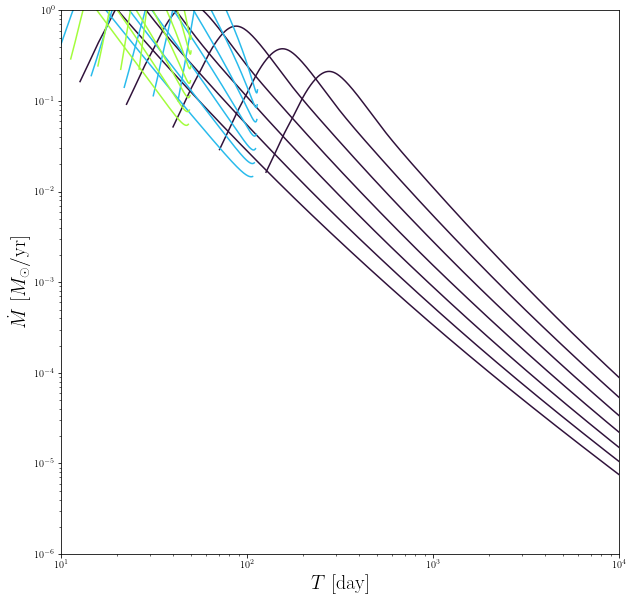

In [13]:
plt.figure(figsize=(10, 10))
Ecc = [1, Ecc114, e_cri_1]
q_range = np.logspace(5, 8, 7)
cmap = cm.get_cmap('turbo', 5)

for level, ecc in enumerate(Ecc):
    tde_temp = [TDE(q=q, Ecc=ecc) for q in q_range]
    for tde in tde_temp:
        plt.loglog(tde.T, tde.dmdt, color=cmap(level))
plt.ylabel('$\dot M\ [M_\odot/\mathrm{yr}]$', fontsize=20)
plt.xlabel('$T\ \mathrm{[day]}$', fontsize=20)
plt.xlim(1e1, 1e4)
plt.ylim(1e-6, 1e0)